In [1]:
# !pip install scitbx
from scitbx.easy_import import *

Command '['C:\\Users\\sz2e24\\AppData\\Local\\anaconda3\\python.exe', '-m', 'pip', 'install', 'git+https://github.com/soonyenju/scigeo.git']' returned non-zero exit status 1., trying another solution...
Command '['C:\\Users\\sz2e24\\AppData\\Local\\anaconda3\\python.exe', '-m', 'pip', 'install', 'git+https://github.com/soonyenju/scieco.git']' returned non-zero exit status 1., trying another solution...
Command '['C:\\Users\\sz2e24\\AppData\\Local\\anaconda3\\python.exe', '-m', 'pip', 'install', 'git+https://github.com/soonyenju/sciml.git']' returned non-zero exit status 1., trying another solution...


In [2]:
def load_s2(p, small = True):
    s2 = geoface.load_tif(p, band_names = [
        'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'
    ]) / 1e4
    s2['NDVI'] = (s2['B8'] - s2['B4']) / (s2['B8'] + s2['B4'])
    s2 = s2['NDVI'].rename('S2 NDVI (10m)'); s2 = s2.where(s2 > 0)
    if small:
        s2 = s2.isel(latitude = slice(300, 600), longitude = slice(700, 1000))
    return s2.drop_vars('spatial_ref')

def load_modis(p):
    modis = geoface.load_tif(p, band_names = [
        'Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2',
        'Nadir_Reflectance_Band3', 'Nadir_Reflectance_Band4',
        'Nadir_Reflectance_Band5', 'Nadir_Reflectance_Band6', 'Nadir_Reflectance_Band7'
    ]) / 1e4
    modis['NDVI'] = (modis['Nadir_Reflectance_Band2'] - modis['Nadir_Reflectance_Band1']) / (modis['Nadir_Reflectance_Band2'] + modis['Nadir_Reflectance_Band1'])
    modis = modis['NDVI'].rename('MODIS NDVI (500m)'); modis = modis.where(modis > 0)
    return modis.drop_vars('spatial_ref')

def proc_modis(modis, s2):
    modis_interp = modis.interp(latitude = s2.latitude, longitude = s2.longitude)
    modis_data = modis_interp.data
    # # Normalize data (0-1)
    # modis_1 = (modis_1 - np.min(modis_1)) / (np.max(modis_1) - np.min(modis_1))
    modis_data[np.isnan(modis_data)] = 0
    # Reshape for CNN input (batch, height, width, channels)
    modis_data = np.expand_dims(modis_data, axis=(0, -1))  # (1, H, W, 1)
    return modis_interp, modis_data

def proc_s2(s):
    s2_data = s2.data
    # # Normalize data (0-1)
    # s2_data = (s2_data - np.min(s2_data)) / (np.max(s2_data) - np.min(s2_data))
    s2_data[np.isnan(s2_data)] = 0
    # Reshape for CNN input (batch, height, width, channels)
    s2_data = np.expand_dims(s2_data, axis=(0, -1))  # (1, H, W, 1)
    return s2_data

In [5]:
s2 = load_s2('data/S2.tif')
modis_1 = load_modis('data/MODIS_1.tif')
modis_2 = load_modis('data/MODIS_2.tif')

In [6]:
s2_data = proc_s2(s2)
modis_interp_1, modis_data_1 = proc_modis(modis_1, s2)
modis_interp_2, modis_data_2 = proc_modis(modis_2, s2)

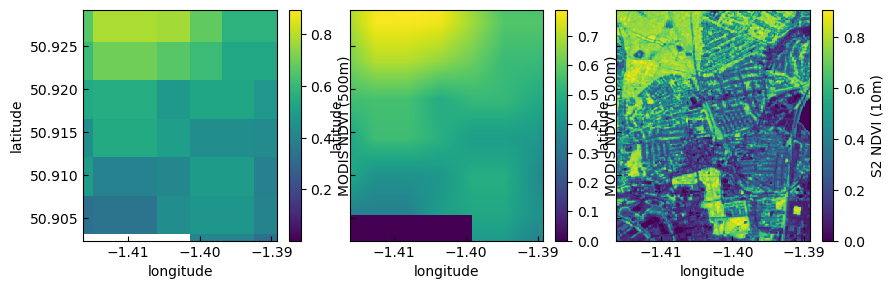

In [7]:
fig, axes = setup_canvas(1, 3, figsize = (10, 3), wspace = 0.1)
ax = axes[0]
modis_1.plot(ax = ax)
ax = axes[1]
modis_interp_1.plot(ax = ax)
ax = axes[2]
s2.plot(ax = ax)

In [ ]:
from sciml.models import TextureFusionSRCNN

model = TextureFusionSRCNN(learning_rate=0.001)
model.train(modis_data_1, s2_data, epochs=50, save_path='texture_fusion_model.keras')

# Load trained model
model = TextureFusionSRCNN.load('texture_fusion_model.keras')

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - loss: 0.0641
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step - loss: 0.0603
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 45s 45s/step - loss: 0.0530
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - loss: 0.0430
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - loss: 0.0301
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - loss: 0.0190
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - loss: 0.0271
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - loss: 0.0844
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - loss: 0.0303
Epoch 10/50


In [ ]:
# Apply model
modis_high = xr.DataArray(
    model.apply(modis_data_2, s2_data),
    dims=("latitude", "longitude"),
    coords={"latitude": s2.latitude, "longitude": s2.longitude},
    name="MODIS NDVI (10m)"
)

In [ ]:
s2.plot(vmin = 0, vmax = 0.8)

In [ ]:
modis_high.plot(vmin = 0, vmax = 0.8)

In [ ]:
dfp = pd.concat([modis_high.to_dataframe(), s2.to_dataframe()], axis = 1)
dfp.plot.scatter(x = 'S2 NDVI (10m)', y = 'MODIS NDVI (10m)')

In [ ]:
dfp = pd.concat([modis_1.rename('MODIS_1').to_dataframe(), modis_1.rename('MODIS_2').to_dataframe()], axis = 1)
dfp.plot.scatter(x = 'MODIS_1', y = 'MODIS_2')